## Financial News Analysis using BERT

<center><h1>Beware of little expenses, a small leak will sink a great ship</h1></center>

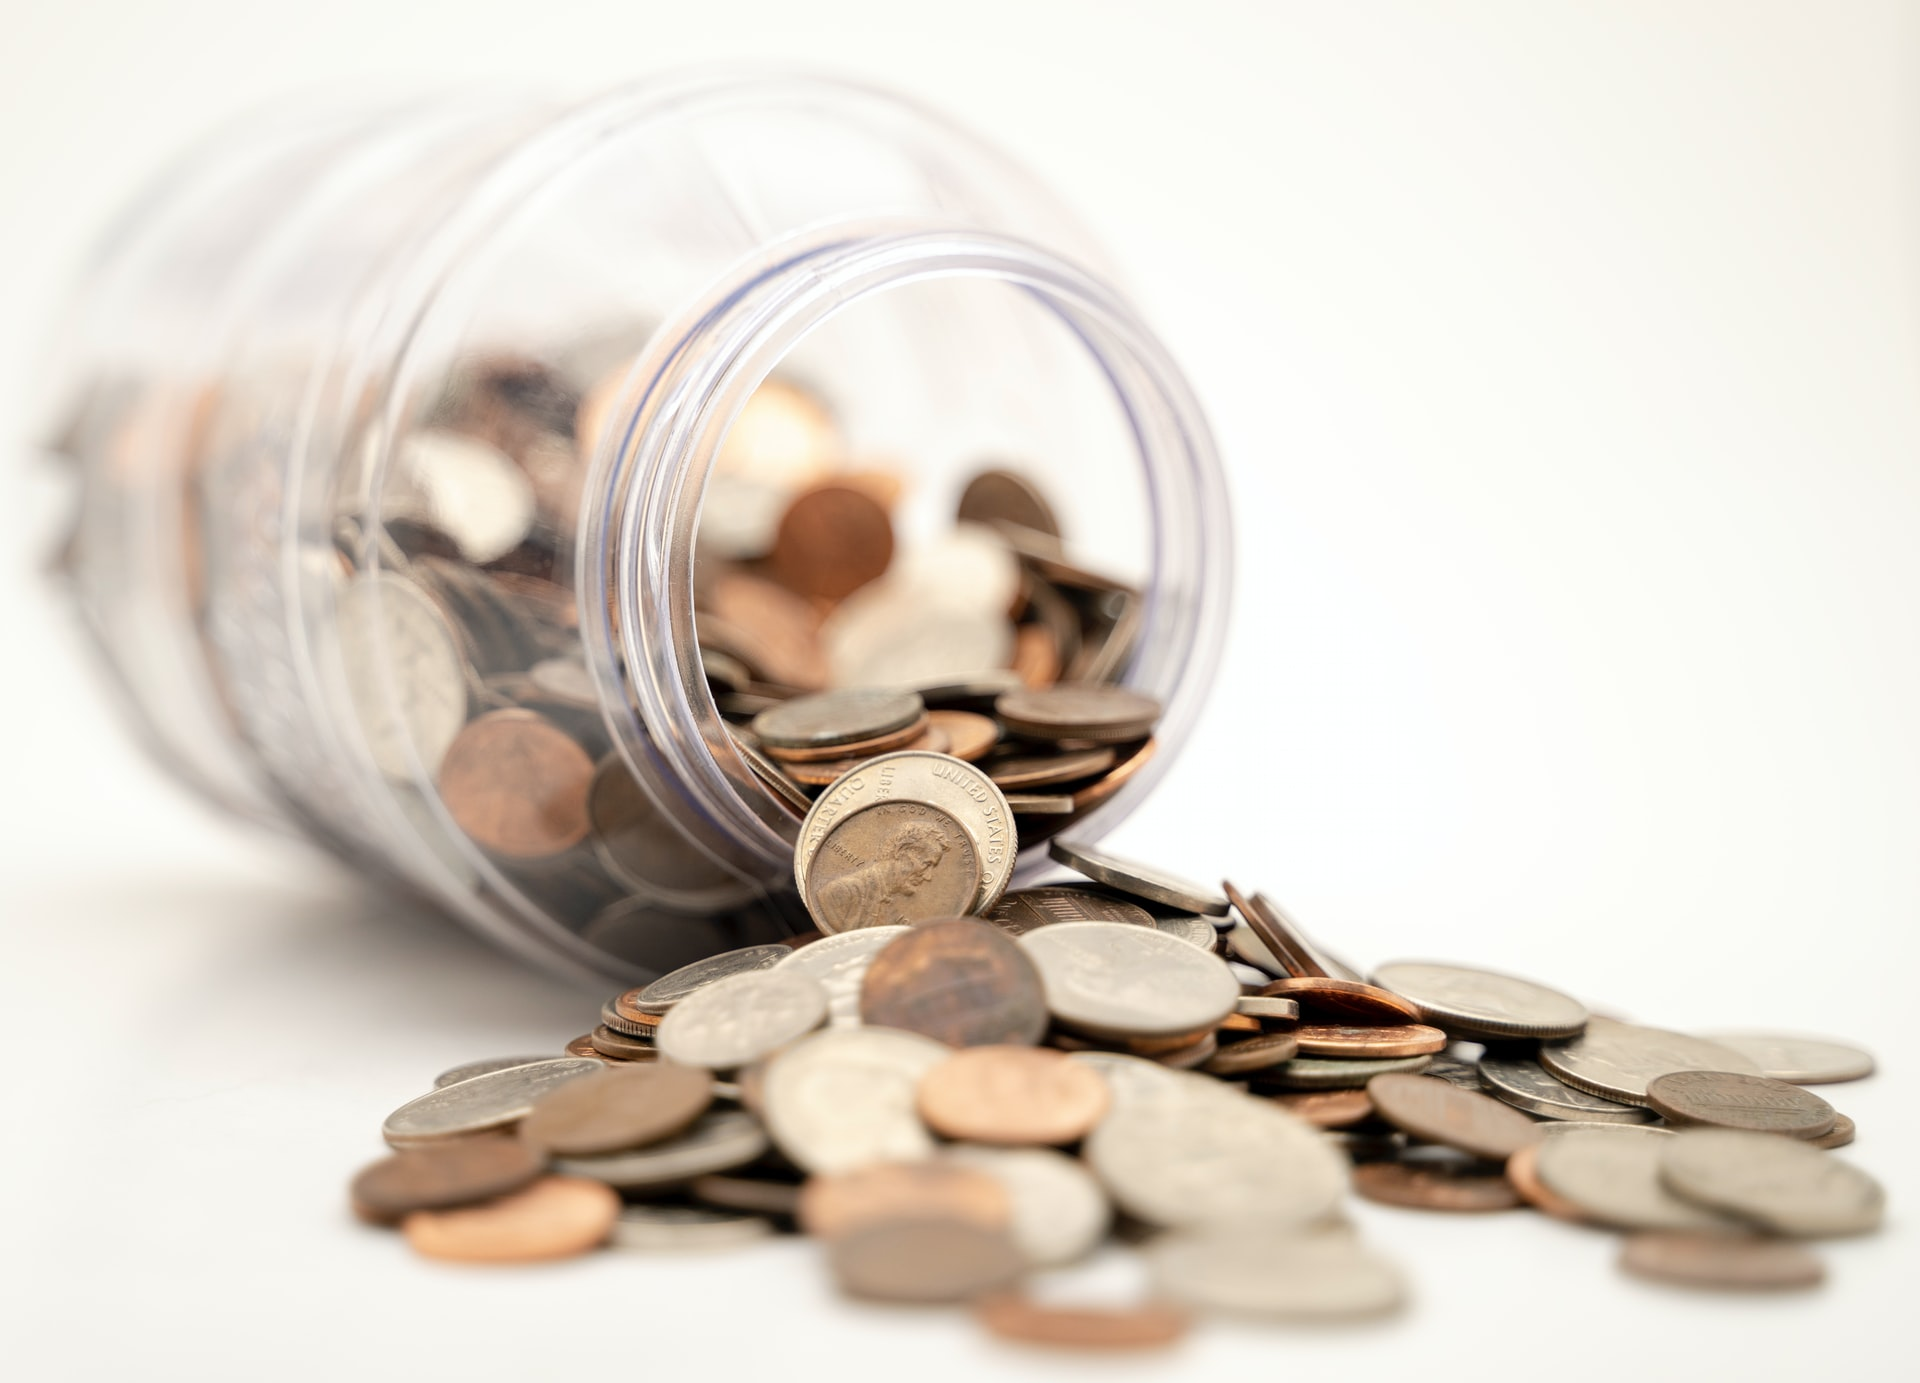

<span>Photo by <a href="https://unsplash.com/@f7photo?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Michael Longmire</a> on <a href="https://unsplash.com/s/photos/finance?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

In [ ]:
!pip3 install ktrain

# Packages Used

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import plotly.graph_objects as go
#import plotly.express as px
import matplotlib.pyplot as plt
import spacy

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS 
import ktrain
from ktrain import text

from collections import Counter

In [ ]:
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', encoding='cp437', header=None)
df.head()

Just need to rename the columns now

In [ ]:
df.columns = ["Sentiment", "News"]
df.head()

Data is ready :)

## Any Null Values?

In [ ]:
df.isnull().sum().any()

Good that no null values are there <br>

What about duplicates?

In [ ]:
df.duplicated().sum()

Out they go.

In [ ]:
df.drop_duplicates(inplace=True)

# Text Cleaning

In [ ]:
nlp = spacy.load('en')

def normalise(msg):
    
    doc = nlp(msg)
    res = []
    
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space or not(token.is_oov): #Removing Stop words and words out of vocabulary
            pass
        else:
            res.append(token.lemma_.lower())
            
    return res

In [ ]:
df['News'] = df['News'].apply(normalise)
df.head()

In [ ]:
fig = go.Figure([go.Bar(x=df.Sentiment.value_counts().index, y=df.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

**The numbers:**

Neutral - 2879<br>
Positve - 1363<br>
Negative - 604<br>

We can map them to numbers before training.

# Visuals in each Sentiment

## Overall Representation 

In [ ]:
words_collection = Counter([item for sublist in df['News'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='YlGnBu', low=0, high=0, axis=0, subset=None)

In [ ]:
word_string = " ".join(words_collection)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=1000,
                      height=650
                         ).generate(word_string)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Let us split it up based on sentiment**

In [ ]:
pos_df = df[df['Sentiment'] == 'positive']
neg_df = df[df['Sentiment'] == 'negative']
neu_df = df[df['Sentiment'] == 'neutral']

## Positive Sentiment Wordcloud

In [ ]:
words_collection = Counter([item for sublist in pos_df['News'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

In [ ]:
word_string = " ".join(words_collection)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=500,
                      height=650
                         ).generate(word_string)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Negative Sentiment Wordcloud

In [ ]:
words_collection = Counter([item for sublist in neg_df['News'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

In [ ]:
word_string = " ".join(words_collection)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=500,
                      height=650
                         ).generate(word_string)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Neutral Sentiment Wordcloud

In [ ]:
words_collection = Counter([item for sublist in neg_df['News'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

In [ ]:
word_string = " ".join(words_collection)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=1500, 
                      width=500,
                      height=650
                         ).generate(word_string)

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Mostly normal stuff like "communication", "network", "worker" are said in neutral news.<br>

Let's convert the sentiment values to numbers before and the lists to string as well before sending it to BERT

In [ ]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

df['News'] = df['News'].apply(lambda m: " ".join(m))

df.head()

# Training BERT

Our data is ready, so let us know send it to BERT.

In [ ]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                    'News',
                                                                    label_columns=['Sentiment'],
                                                                   maxlen=500,
                                                                    preprocess_mode='bert')

In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

In [ ]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [ ]:
learner.fit_onecycle(lr=2e-5,
                     epochs=1)

# Final Notes

Things I might look to rectify is maybe give a better visualisation of the sentiments perhaps but I don't really know what exactly.